pip install torch torchvision open_clip_torch pillow matplotlib pandas

In [ ]:
import os
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import open_clip
import tqdm as notebook_tqdm

# Enable inline plotting
%matplotlib inline

c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === CONFIGURATION ===
image_folder = "./Dataset/Train/2_Enhance"
output_csv = "./Output/CLIP/clip_ranked_results.csv"
output_plot = "./Output/CLIP/clip_rank_plot.png"
output_good_folder = "./Output/CLIP/3_Good"
good_threshold = 0.2

In [3]:
# === LOAD MODEL ===
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

In [ ]:
# === PROMPTS ===
positive_prompt = "young, friendly, energetic"
negative_prompt = (
    "bad_anatomy,bad_hands,three_hands,three_legs,bad_arms,missing_legs,missing_arms,"
    "poorly_drawn_face,poorly_rendered_hands,bad_face,fused_face,cloned_face,worst_face,"
    "three_crus,extra_crus,fused_crus,worst_feet,three_feet,fused_feet,fused_thigh,three_thigh,"
    "extra_thigh,worst_thigh,missing_fingers,extra_fingers,ugly_fingers,long_fingers,bad_composition,"
    "horn,extra_eyes,huge_eyes,2girl,amputation,disconnected_limbs,cartoon,cg,3d,unreal,animate,cgi,"
    "render,artwork,illustration,3d_render,cinema_4d,artstation,octane_render,mutated_body_parts,painting,"
    "oil_painting,2d,sketch,bad_photography,bad_photo,deviant_art,aberrations,abstract,anime,"
    "black_and_white,collapsed,conjoined,creative,drawing,extra_windows,harsh_lighting,jpeg_artifacts,"
    "low_saturation,monochrome,multiple_levels,overexposed,oversaturated,photoshop,rotten,surreal,"
    "twisted,UI,underexposed,unnatural,unreal_engine,unrealistic,video_game,deformed_body_features"
)

In [5]:
# === ENCODE PROMPTS ===
positive_tokens = tokenizer([positive_prompt]).to(device)
negative_tokens = tokenizer([negative_prompt]).to(device)
with torch.no_grad():
    pos_embed = model.encode_text(positive_tokens).float()
    neg_embed = model.encode_text(negative_tokens).float()
    pos_embed /= pos_embed.norm(dim=-1, keepdim=True)
    neg_embed /= neg_embed.norm(dim=-1, keepdim=True)

In [6]:
# === PROCESS IMAGES ===
results = []
for fname in os.listdir(image_folder):
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        path = os.path.join(image_folder, fname)
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                img_embed = model.encode_image(image).float()
                img_embed /= img_embed.norm(dim=-1, keepdim=True)
                pos_score = (img_embed @ pos_embed.T).item()
                neg_score = (img_embed @ neg_embed.T).item()
                score = pos_score - neg_score
                results.append((fname, score, pos_score, neg_score))
        except Exception as e:
            print(f"Error processing {fname}: {e}")

In [7]:
# === RANKING ===
results.sort(key=lambda x: x[1], reverse=True)
df = pd.DataFrame(results, columns=["Image", "Score", "Positive", "Negative"])
df.insert(0, "Rank", range(1, len(df)+1))

# Show table
df.head(20)  # Show top 20 in the notebook

,Rank,Image,Score,Positive,Negative
0,1,Untitled (40).png,0.181841,0.283225,0.101384
1,2,Untitled (41).png,0.176508,0.285904,0.109396
2,3,Untitled (48).png,0.168169,0.258292,0.090123
3,4,Untitled (49).png,0.157915,0.261279,0.103363
4,5,Untitled (62).png,0.151266,0.291378,0.140112
5,6,Untitled (3).png,0.150121,0.288567,0.138447
6,7,Untitled (26).png,0.148206,0.267371,0.119164
7,8,Dzine72.PNG,0.146741,0.308466,0.161726
8,9,Dzine21.PNG,0.143341,0.254133,0.110792
9,10,Untitled (12).png,0.136923,0.276149,0.139226


In [8]:
# === SAVE CSV ===
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df.to_csv(output_csv, index=False)
print(f"CSV saved to: {output_csv}")

CSV saved to: ./Output/CLIP/clip_ranked_results.csv


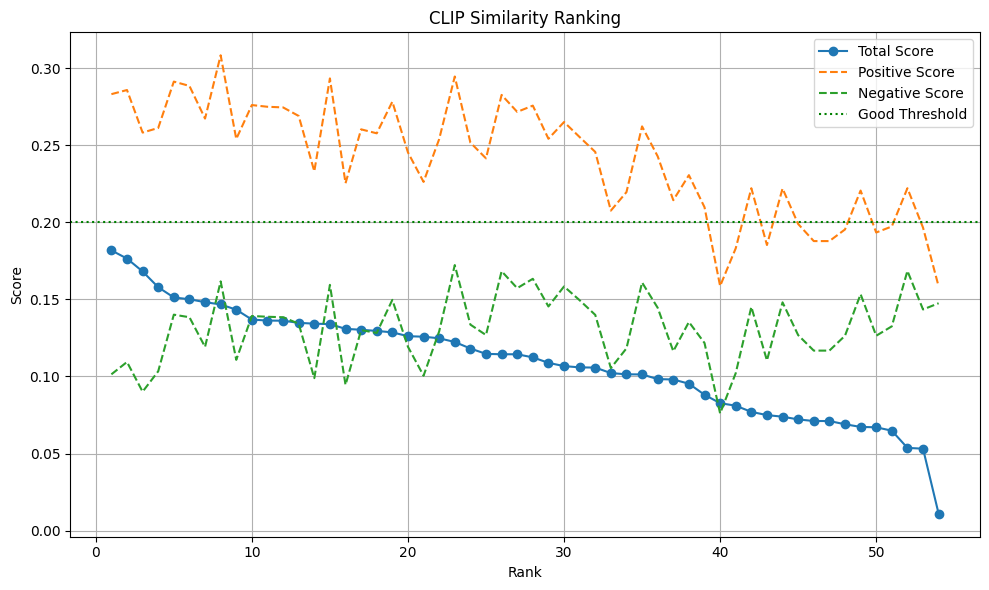

Plot saved to: ./Output/CLIP/clip_rank_plot.png


In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df["Rank"], df["Score"], marker='o', label='Total Score')
plt.plot(df["Rank"], df["Positive"], linestyle='--', label='Positive Score')
plt.plot(df["Rank"], df["Negative"], linestyle='--', label='Negative Score')
plt.axhline(y=good_threshold, color='green', linestyle=':', label='Good Threshold')
plt.title("CLIP Similarity Ranking")
plt.xlabel("Rank")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(output_plot)
plt.show()
print(f"Plot saved to: {output_plot}")

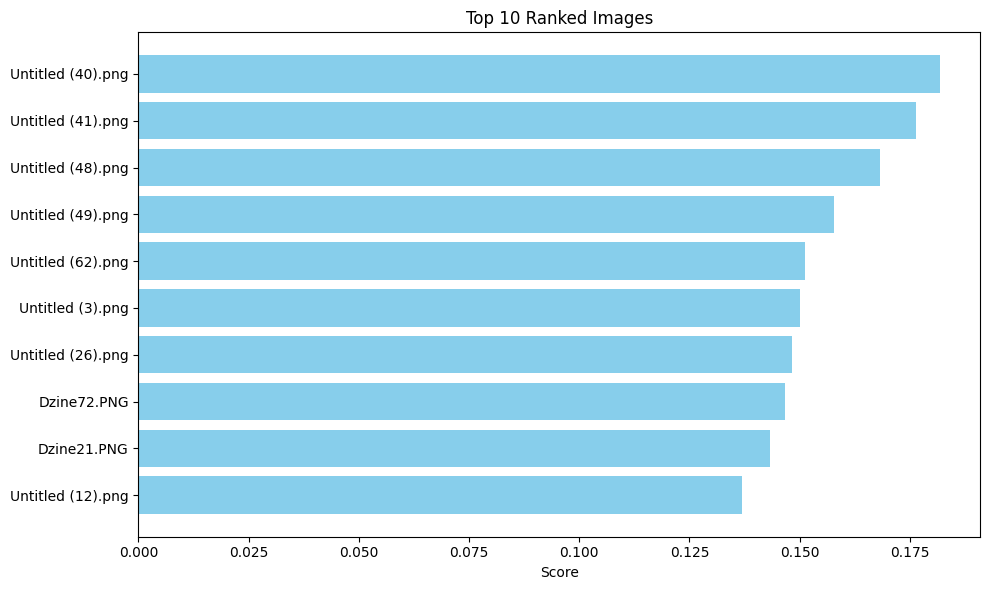

In [10]:
top10 = df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["Image"][::-1], top10["Score"][::-1], color='skyblue')
plt.xlabel("Score")
plt.title("Top 10 Ranked Images")
plt.tight_layout()
plt.show()


In [11]:
# === SAVE GOOD IMAGES ===
os.makedirs(output_good_folder, exist_ok=True)
for _, row in df.iterrows():
    if row["Score"] >= good_threshold:
        src = os.path.join(image_folder, row["Image"])
        dst = os.path.join(output_good_folder, row["Image"])
        try:
            Image.open(src).save(dst)
        except Exception as e:
            print(f"Failed to copy {row['Image']}: {e}")

print(f"Filtered good images saved to: {output_good_folder}")

Filtered good images saved to: ./Output/CLIP/3_Good
